In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
dbname = os.getenv('DB_NAME')

DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"

engine = create_engine(DATABASE_URL)

In [3]:
df = pd.read_sql("SELECT * FROM data_ml", engine)

In [4]:
features = ["total_spent","avg_ticket","max_ticket","total_orders",
            "total_items","avg_items_per_order","unique_payment_types","first_last_difference_days","recency_days"]
df_features = df[features].copy()
df_features

,total_spent,avg_ticket,max_ticket,total_orders,total_items,avg_items_per_order,unique_payment_types,first_last_difference_days,recency_days
0,141.90,141.90,141.90,1,1,1.0,1,0,111
1,27.19,27.19,27.19,1,1,1.0,1,0,114
2,86.22,86.22,86.22,1,1,1.0,1,0,536
3,43.62,43.62,43.62,1,1,1.0,1,0,320
4,196.89,196.89,196.89,1,1,1.0,1,0,287
...,...,...,...,...,...,...,...,...,...
93352,4134.84,2067.42,2067.42,1,2,2.0,1,0,446
93353,84.58,84.58,84.58,1,1,1.0,1,0,261
93354,112.46,112.46,112.46,1,1,1.0,1,0,567
93355,133.69,133.69,133.69,1,1,1.0,1,0,118


In [5]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
total_spent,93357.0,211.833718,642.166523,9.59,63.76,112.95,201.74,109312.64
avg_ticket,93357.0,160.450078,219.725771,9.59,62.39,105.70,176.76,13664.08
max_ticket,93357.0,161.801052,221.287026,9.59,62.64,106.38,178.22,13664.08
total_orders,93357.0,1.033420,0.209099,1.00,1.00,1.00,1.00,15.00
total_items,93357.0,1.180351,0.620832,1.00,1.00,1.00,1.00,24.00
avg_items_per_order,93357.0,1.139511,0.527042,1.00,1.00,1.00,1.00,21.00
unique_payment_types,93357.0,1.026222,0.160731,1.00,1.00,1.00,1.00,3.00
first_last_difference_days,93357.0,2.634061,24.955954,0.00,0.00,0.00,0.00,633.00
recency_days,93357.0,236.936673,152.584315,0.00,113.00,218.00,345.00,694.00


In [ ]:
# Se visualizan desviacion estandar y coef de variacion
stats = pd.DataFrame({
    "mean": df_features.mean(),
    "std": df_features.std(),
})

stats["cv"] = stats["std"] / stats["mean"]
stats.sort_values("cv", ascending=False)

,mean,std,cv
first_last_difference_days,2.634061,24.955954,9.474328
total_spent,211.833718,642.166523,3.031465
avg_ticket,160.450078,219.725771,1.369434
max_ticket,161.801052,221.287026,1.367649
recency_days,236.936673,152.584315,0.643988
total_items,1.180351,0.620832,0.525973
avg_items_per_order,1.139511,0.527042,0.462516
total_orders,1.033420,0.209099,0.202336
unique_payment_types,1.026222,0.160731,0.156624


In [ ]:
# Se visualiza los valores skew para ver que tan sesgados estan
df_features.skew().sort_values(ascending=False)

total_spent                   70.336263
first_last_difference_days    12.306065
total_orders                  11.095096
avg_ticket                     9.401163
max_ticket                     9.309544
avg_items_per_order            7.625461
total_items                    7.443850
unique_payment_types           6.037977
recency_days                   0.447277
dtype: float64


In [ ]:
# Se aplica escala logaritmica
cols_to_log = [
    "total_spent",
    "avg_ticket",
    "max_ticket",
    "total_orders",
    "first_last_difference_days",
    "total_items",
    "avg_items_per_order",
    "unique_payment_types"
]

for col in cols_to_log:
    df_features[col] = np.log1p(df_features[col])

In [ ]:
# Valores estandarizados 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features)

c:\Users\fredd\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\fredd\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\fredd\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\fredd\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c

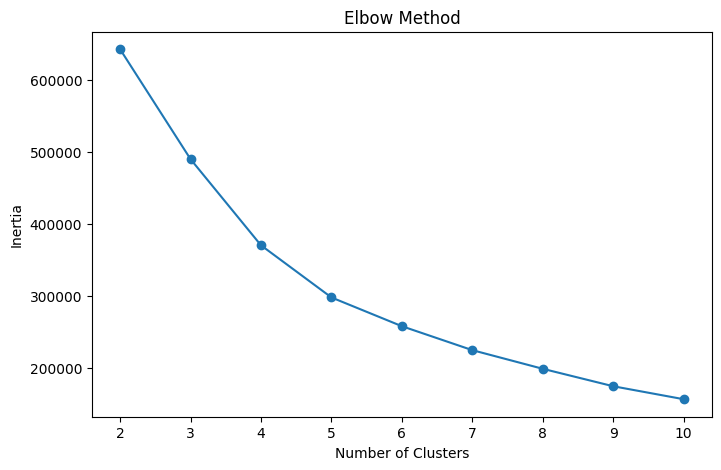

In [ ]:
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [ ]:
# Muestra aleatoria "10000"
sample_size = 10000
idx = np.random.choice(len(scaled_data), sample_size, replace=False)
sample_data = scaled_data[idx]

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(sample_data)
    score = silhouette_score(sample_data, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.5365
K=3, Silhouette Score=0.3478
K=4, Silhouette Score=0.3519
K=5, Silhouette Score=0.3052


*Tras evaluar los métodos del Codo y de la Silueta, los resultados indican que el número óptimo de clústeres es K=2. No obstante, con el objetivo de extraer insights más valiosos y obtener una segmentación más variada, se optará por utilizar K=4*

In [ ]:
# Configuracion de numero de K
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_data)
# Nueva columna "cluster" añadida en el df original
df["cluster"] = cluster_labels

In [ ]:
# Preparacion de datos para visualizacion T-SNE
sample_size = 10000
idx = np.random.choice(len(scaled_data), sample_size, replace=False)

sample_scaled = scaled_data[idx]
sample_clusters = df["cluster"].iloc[idx].values

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    max_iter=1000
)

tsne_results = tsne.fit_transform(sample_scaled)

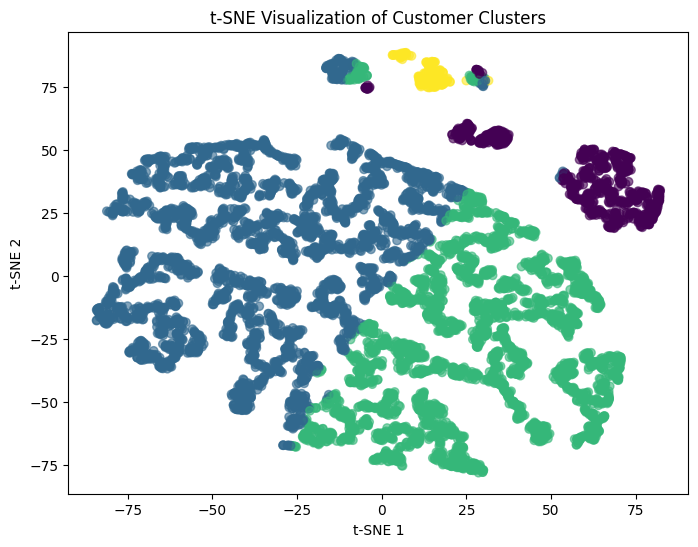

In [30]:
# Visualizacion de clusters con T-SNE
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    tsne_results[:,0],
    tsne_results[:,1],
    c=sample_clusters,
    alpha=0.6
)

plt.title("t-SNE Visualization of Customer Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [ ]:
# Agrupacion de clusters y media de columnas numericas
cluster_profile = df.groupby("cluster")[features].mean()
cluster_profile

,total_spent,avg_ticket,max_ticket,total_orders,total_items,avg_items_per_order,unique_payment_types,first_last_difference_days,recency_days
cluster,,,,,,,,,
0,708.589272,249.255367,250.369454,1.022339,2.447224,2.403273,1.020663,0.002904,239.838378
1,64.322094,63.895103,63.959595,1.006443,1.007645,1.001201,1.023764,0.000109,240.609659
2,261.535531,259.964619,260.399327,1.008329,1.008329,1.000000,1.020836,0.000027,234.068105
3,454.708196,151.094848,199.708931,2.159420,2.611694,1.202794,1.205897,122.876562,192.412794


In [ ]:
# Porcentajes de clientes en cada cluster
df["cluster"].value_counts(normalize=True) * 100

cluster
1    49.040779
2    39.225768
0     9.590068
3     2.143385
Name: proportion, dtype: float64

---

# Customer Segmentation – Cluster Insights

---

## Estructura General de la Base

- El 97.8% de los clientes realiza únicamente **una compra**.
- Solo el 2.14% presenta **comportamiento recurrente real**.
- La mayoría de los clusters muestran una diferencia casi nula entre primera y última compra, lo que confirma baja retención.

**Conclusión general:**  
El negocio muestra una fuerte dependencia de clientes one-shot. La principal oportunidad estratégica está en mejorar la retención y estimular la segunda compra.

---

## Cluster 1 (49.04%) – Low Value Ticket One-Time Buyers

**Características promedio:**
- Total spent ≈ 64
- 1 orden
- 1 ítem por orden
- Sin recurrencia
- Recency ≈ 240 días

**Interpretación:**
Es el segmento más grande. Clientes de bajo gasto que no regresan después de su primera compra.

**Insight clave:**
Gran volumen, bajo valor individual y nula fidelización.

---

## Cluster 2 (39.22%) – Medium value Ticket One-Time Buyers

**Características promedio:**
- Total spent ≈ 261
- 1 orden
- 1 ítem
- Sin recurrencia
- Recency ≈ 234 días

**Interpretación:**
Clientes con mayor capacidad de gasto que realizan una única compra.

**Insight clave:**
Existe potencial de retención en un segmento con ticket medio-alto.

---

## Cluster 0 (9.59%) – High Value Bulk Buyers

**Características promedio:**
- Total spent ≈ 708
- ~2.4 ítems por orden
- 1 orden
- Sin recurrencia significativa

**Interpretación:**
Clientes que realizan compras grandes en una sola transacción.

**Insight clave:**
Alto valor por cliente, pero baja frecuencia. Posible oportunidad en recompra dirigida.

---

## Cluster 3 (2.14%) – Loyal Customers

**Características promedio:**
- ~2.15 órdenes
- ~2.6 ítems
- 122 días entre primera y última compra
- Mejor recency (~192 días)

**Interpretación:**
Único segmento con comportamiento de recurrencia real.

**Insight clave:**
Pequeño en tamaño, pero estratégicamente el más saludable.

---

# Insights Estrategicos

- El problema principal no es adquisición, sino retención.
- El negocio depende casi completamente de clientes de una sola compra.
- El crecimiento sostenible debería enfocarse en:
  - Incrementar la segunda compra.
  - Diseñar estrategias de fidelización.
  - Analizar fricción post-primera compra.
